# Sea Surface Height (SSH) trends

This Jupyter notebook shows how to compute the SSH trend maps reported in the manuscript "Global changes in oceanic mesoscale currents over the satellite altimetry record".

In [1]:
# Import libraries
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs

import pylab as plt
import numpy as np
# Inline plotting
%matplotlib inline

#### Import Mann Kendall test:

In [2]:
from xarrayMannKendall import Mann_Kendall_test

In [3]:
from utils import area,ccrs_land,add_patches
import datetime as datetime

In [4]:
from dask.distributed import Client

In [5]:
c = Client()
c

Client Scheduler: tcp://127.0.0.1:44571 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 36 Memory: 154.62 GB


In [6]:
dataset_SSH = xr.open_mfdataset('/g/data/ua8/CMEMS_SeaLevel/v2019/*/*.nc',parallel=True)
# dataset_SSH = xr.open_mfdataset('path2AVISO+/*.nc')

In [7]:
dataset_SSH

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 9928)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-03-07
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
Data variables:
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds   (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2019-01-17T16:58:50Z
    date_issued:                     2019-01-17T16:58:50Z
    date_modified:                   2019-01-17T16:58:50Z
    geospatial_lat_max:              89.875
    geospatial_lat_min:              -89.875
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.875
    geospatial_lon_min:              0.125
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2019-01-17 16:58:51Z: Creation
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        ERS-1, Topex/Poseidon,
    processing_level:                L4
    product_version:                 2019
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    software_version:                6.2_DUACS_DT2018_baseline
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1993-01-01T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [8]:
SSH_coarsen = dataset_SSH.adt.coarsen({'latitude':4,'longitude':4}).mean().compute()

In [9]:
SSH = SSH_coarsen.to_dataset(name="SSH")

In [10]:
SSH.attrs['title'] = "Sea Surface Height"
SSH.attrs['Description'] = """Sea Surface Height computed from AVISO+ altimetry. Then trends were computed using a modified Mann-Kendall test. \n See: https://github.com/josuemtzmo/xarrayMannKendall."""
SSH.attrs['Publication'] = "Dataset created for Martínez-Moreno, J. et. al. 2020: \n 'Mesoscale kinetic energy response to changing oceans'"
SSH.attrs['Author'] = "Josué Martínez-Moreno"
SSH.attrs['Contact'] = "josue.martinezmoreno@anu.edu.au"

SSH.attrs['Created date'] = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

######################################################

SSH['SSH'].attrs['units'] = r"$m$"
SSH['SSH'].attrs['name'] = 'trend'
SSH['SSH'].attrs['long_name'] = "Sea Surface Height"

SSH['SSH'].attrs['missing_value'] = np.nan
SSH['SSH'].attrs['valid_min'] = np.nanmin(SSH['SSH'])
SSH['SSH'].attrs['valid_max'] = np.nanmax(SSH['SSH'])
SSH['SSH'].attrs['valid_range'] = [np.nanmin(SSH['SSH']),np.nanmax(SSH['SSH'])]

In [11]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in SSH.data_vars}

SSH.to_netcdf('../datasets/SSH_timeseries.nc', encoding=encoding)

In [12]:
# Print function used.
?Mann_Kendall_test

Init signature:
Mann_Kendall_test(
    DataArray,
    dim='time',
    alpha=0.01,
    MK_modified=False,
    method='linregress',
    coords_name=None,
)
Docstring:     
Compute linear trends and significance using Mann Kendall test.

Parameters
----------
DataArray : xarray.DataArray
    Dataset to analyse.
dim : str
    Coordiante name in which the linear trend will apply ('time').
alpha: float
    Significance level (default = 0.01)
MK_modified: Boolean
    Modified Mann-Kendall using Yue and Wang (2004) method.
    DOI: https://doi.org/10.1023/B:WARM.0000043140.61082.60
method: str
    Method for linear regresion: linregress (default) and theilslopes
coords_name: dict
    Coordinates name dict renames coordinates to 'lon','lat'. 
    Example:   
        coords_name={'xu_ocean':'lon','yu_ocean':'lat','t':time}
        
Example:

    # Time series length
    n=100
    time = np.arange(n)
    # Grid
    x = np.arange(4)
    y = np.arange(4)
    
    # Create dataarray
    data = np.ze

For more information in the Mann-Kendall method, please refer to: https://doi.org/10.1023/B:WARM.0000043140.61082.60

The reported trends use a modified Mann-Kendall method. A modified Mann-Kendall test is used to assess statistical significance of trends, while properly taking into account the autocorrelation in the time-series. The effective sample size for all the reported trends is always smaller than the actual sample size, due to autocorrelation of the time series. 

In [13]:
SSH = xr.open_dataset('../datasets/SSH_timeseries.nc',chunks={'latitude':10,'longitude':10}).SSH

In [14]:
ssh_trends = Mann_Kendall_test(SSH,'time',MK_modified=True,
                               method="linregress",alpha=0.05, 
                               coords_name = {'time':'time','x':'longitude','y':'latitude'})

SSHNote that the following cell will take ~1 hour depending on the number of cores, as the Mann-Kendall method requirest to invert a matrix of shape (len(time),len(time)) for each grid point.

In [15]:
SSH_trends = ssh_trends.compute()

In [16]:
SSH_trends.attrs['title'] = "Sea Surface Height trends"
SSH_trends.attrs['Description'] = """Sea Surface Height trends computed from AVISO+ altimetry. Then trends were computed using a modified Mann-Kendall test. \n See: https://github.com/josuemtzmo/xarrayMannKendall."""
SSH_trends.attrs['Publication'] = "Dataset created for Martínez-Moreno, J. et. al. 2020: \n 'Mesoscale kinetic energy response to changing oceans'"
SSH_trends.attrs['Author'] = "Josué Martínez-Moreno"
SSH_trends.attrs['Contact'] = "josue.martinezmoreno@anu.edu.au"

SSH_trends.attrs['Created date'] = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

######################################################

SSH_trends['trend'].attrs['units'] = r"$m day^{-1}$"
SSH_trends['trend'].attrs['name'] = 'trend'
SSH_trends['trend'].attrs['long_name'] = "Sea Surface Height trends"

SSH_trends['trend'].attrs['missing_value'] = np.nan
SSH_trends['trend'].attrs['valid_min'] = np.nanmin(SSH_trends['trend'])
SSH_trends['trend'].attrs['valid_max'] = np.nanmax(SSH_trends['trend'])
SSH_trends['trend'].attrs['valid_range'] = [np.nanmin(SSH_trends['trend']),np.nanmax(SSH_trends['trend'])]

######################################################

SSH_trends['signif'].attrs['units'] = ""
SSH_trends['signif'].attrs['name'] = 'signif'
SSH_trends['signif'].attrs['long_name'] = "Sea Surface Height trends significance"

SSH_trends['signif'].attrs['missing_value'] = np.nan
SSH_trends['signif'].attrs['valid_min'] = np.nanmin(SSH_trends['signif'])
SSH_trends['signif'].attrs['valid_max'] = np.nanmax(SSH_trends['signif'])
SSH_trends['signif'].attrs['valid_range'] = [np.nanmin(SSH_trends['signif']),np.nanmax(SSH_trends['signif'])]

######################################################

SSH_trends['p'].attrs['units'] = ""
SSH_trends['p'].attrs['name'] = 'p'
SSH_trends['p'].attrs['long_name'] = "Sea Surface Height trends p"

SSH_trends['p'].attrs['missing_value'] = np.nan
SSH_trends['p'].attrs['valid_min'] = np.nanmin(SSH_trends['p'])
SSH_trends['p'].attrs['valid_max'] = np.nanmax(SSH_trends['p'])
SSH_trends['p'].attrs['valid_range'] = [np.nanmin(SSH_trends['p']),np.nanmax(SSH_trends['p'])]

In [17]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in SSH_trends.data_vars}

SSH_trends.to_netcdf('../datasets/SSH_trends.nc', encoding=encoding)

In [18]:
SSH_trends

<xarray.Dataset>
Dimensions:    (x: 360, y: 180)
Coordinates:
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y          (y) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    trend      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    signif     (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    p          (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    std_error  (y, x) float64 ...
Attributes:
    title:         Sea Surface Height trends
    Description:   Sea Surface Height trends computed from AVISO+ altimetry. ...
    Publication:   Dataset created for Martínez-Moreno, J. et. al. 2020: \n '...
    Author:        Josué Martínez-Moreno
    Contact:       josue.martinezmoreno@anu.edu.au
    Created date:  21/01/2021 16:06:54

In [19]:
trends = SSH_trends.trend*10*365 # Convert to trends per decade

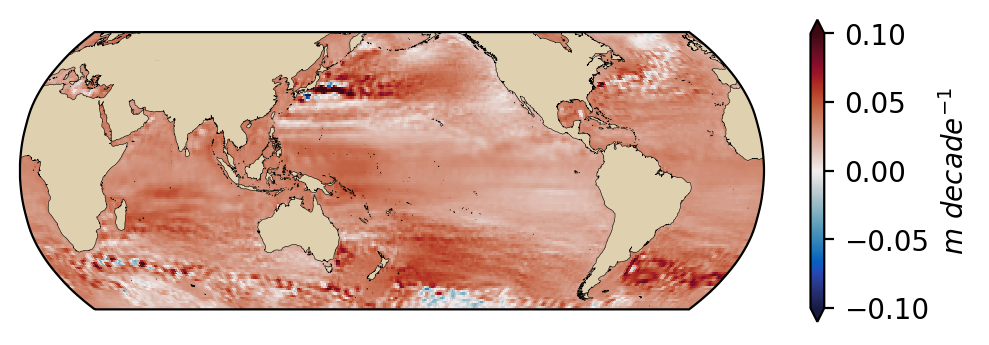

In [20]:
fig = plt.figure(figsize=(6,2), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude=180))

im = trends.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$m\ decade^{-1}$"),
              cmap=cm.cm.balance, vmin=-0.1, vmax=0.1,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
add_patches(ax)